In [1]:
import pandas as pd
import fsrs_optimizer

timezone = "Europe/Moscow"
next_day_starts_at = 5
revlog_start_date = "2006-10-05"  # YYYY-MM-DD
filter_out_suspended_cards = False
filter_out_flags = []

In [ ]:
from anki.collection import Collection


optimizer = fsrs_optimizer.Optimizer()
optimizer.anki_extract("./Main_27.04.2023.apkg",
                       filter_out_suspended_cards, filter_out_flags)
optimizer.create_time_series(
    timezone, revlog_start_date, next_day_starts_at, analysis=False)

col = Collection("./collection.anki21")
decks = [item.name for item in tuple(col.decks.all_names_and_ids()) if sum([col.get_card(cid).reps for cid in col.find_cards(f"deck:{item.name}")]) >= 1000]

def remove_substrings(lst):
    # Sort the list by length of the strings, longest first
    lst.sort(key=len, reverse=True)

    # List to hold the filtered items
    filtered_list = []

    for item in lst:
        # Add the item to the filtered list if it is not a substring of any item already in the filtered list
        if not any(item in other_item for other_item in filtered_list):
            filtered_list.append(item)

    return filtered_list

decks_for_cluster = remove_substrings(decks)
df = pd.read_csv("./revlog_history.tsv", sep="\t", dtype={"first_rating": str})
dfs = [(name, df[df['card_id'].isin(tuple(col.find_cards(f"deck:{name}")))].copy(
)) for name in decks_for_cluster]

In [3]:
ws = []
datasets = []

for name, df in dfs:
    optimizer.define_model()
    S0_dataset = df[df["i"] == 2].copy()
    optimizer.S0_dataset_group = (
        S0_dataset.groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.pretrain(df.copy(), verbose=False)
    optimizer.train(verbose=False)
    datasets.append(optimizer.dataset.copy())
    ws.append(optimizer.w)

  0%|          | 0/30819 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/22587 [00:00<?, ?it/s]

  0%|          | 0/1342 [00:00<?, ?it/s]

  0%|          | 0/5864 [00:00<?, ?it/s]

  0%|          | 0/1287 [00:00<?, ?it/s]

  0%|          | 0/15200 [00:00<?, ?it/s]

  0%|          | 0/2292 [00:00<?, ?it/s]

  0%|          | 0/52207 [00:00<?, ?it/s]

  0%|          | 0/4587 [00:00<?, ?it/s]

log loss: 0.3512
RMSE(bins): 0.0299

Last rating: 1
RMSE(bins): 0.0566

Last rating: 2
RMSE(bins): 0.0405

Last rating: 3
RMSE(bins): 0.0304

Last rating: 4
RMSE(bins): 0.0372


({'all': {'R-squared': 0.9117339625300421,
   'MAE': 0.015218409477080684,
   'ICI': 0.014722751387082636,
   'E50': 0.008759116715361337,
   'E90': 0.023242593252314835,
   'EMax': 0.2969232932657236,
   'RMSE(bins)': 0.029935759134763675,
   'AUC': 0.735881719303604},
  1: {'R-squared': 0.6301177559381061,
   'MAE': 0.0582724915333185,
   'ICI': 0.05493910064972469,
   'E50': 0.04618773541530502,
   'E90': 0.1092012597294688,
   'EMax': 0.24926106735684325,
   'RMSE(bins)': 0.0566172110713959,
   'AUC': 0.6959470810150405},
  2: {'R-squared': 0.9185066111312412,
   'MAE': 0.02526189166794265,
   'ICI': 0.02191904337435431,
   'E50': 0.021600079496941205,
   'E90': 0.02871314564751173,
   'EMax': 0.2137711442564082,
   'RMSE(bins)': 0.04046194066254761,
   'AUC': 0.7137874338526852},
  3: {'R-squared': 0.8914003416103621,
   'MAE': 0.011291208760139048,
   'ICI': 0.010302367055742825,
   'E50': 0.0017871000952957017,
   'E90': 0.027811519863647667,
   'EMax': 0.2995750224138691,
   'R

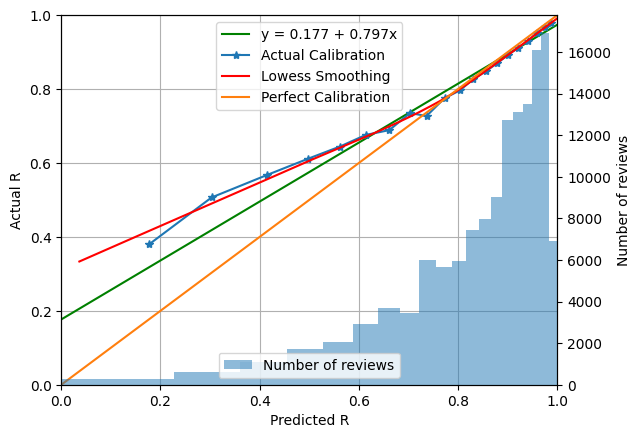

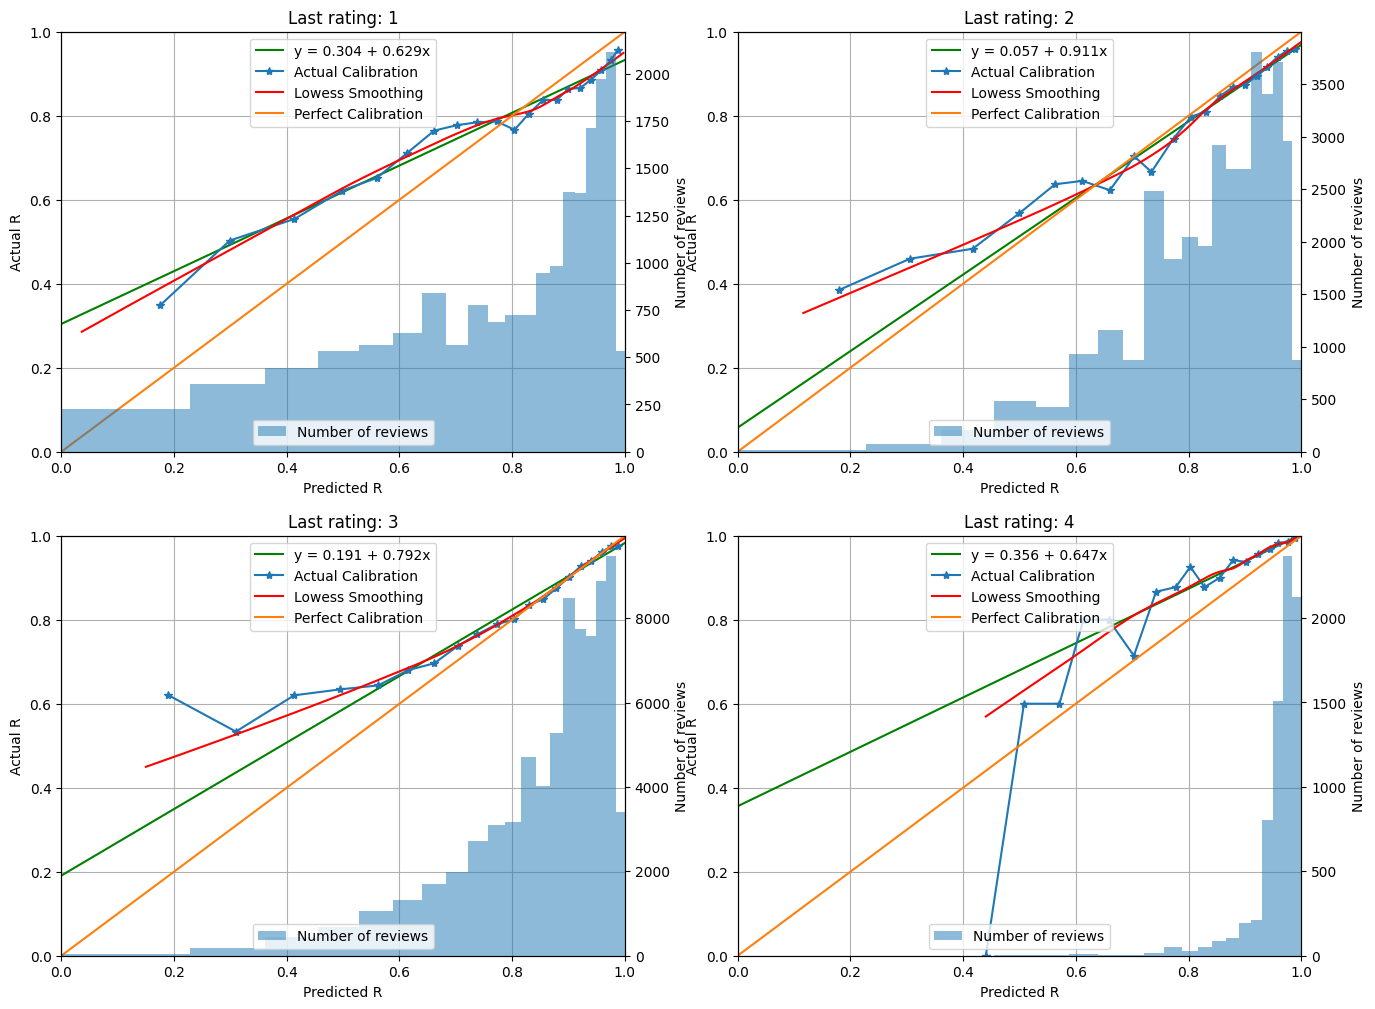

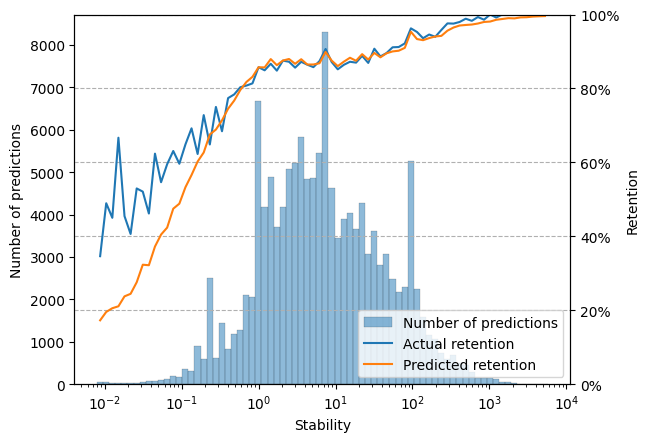

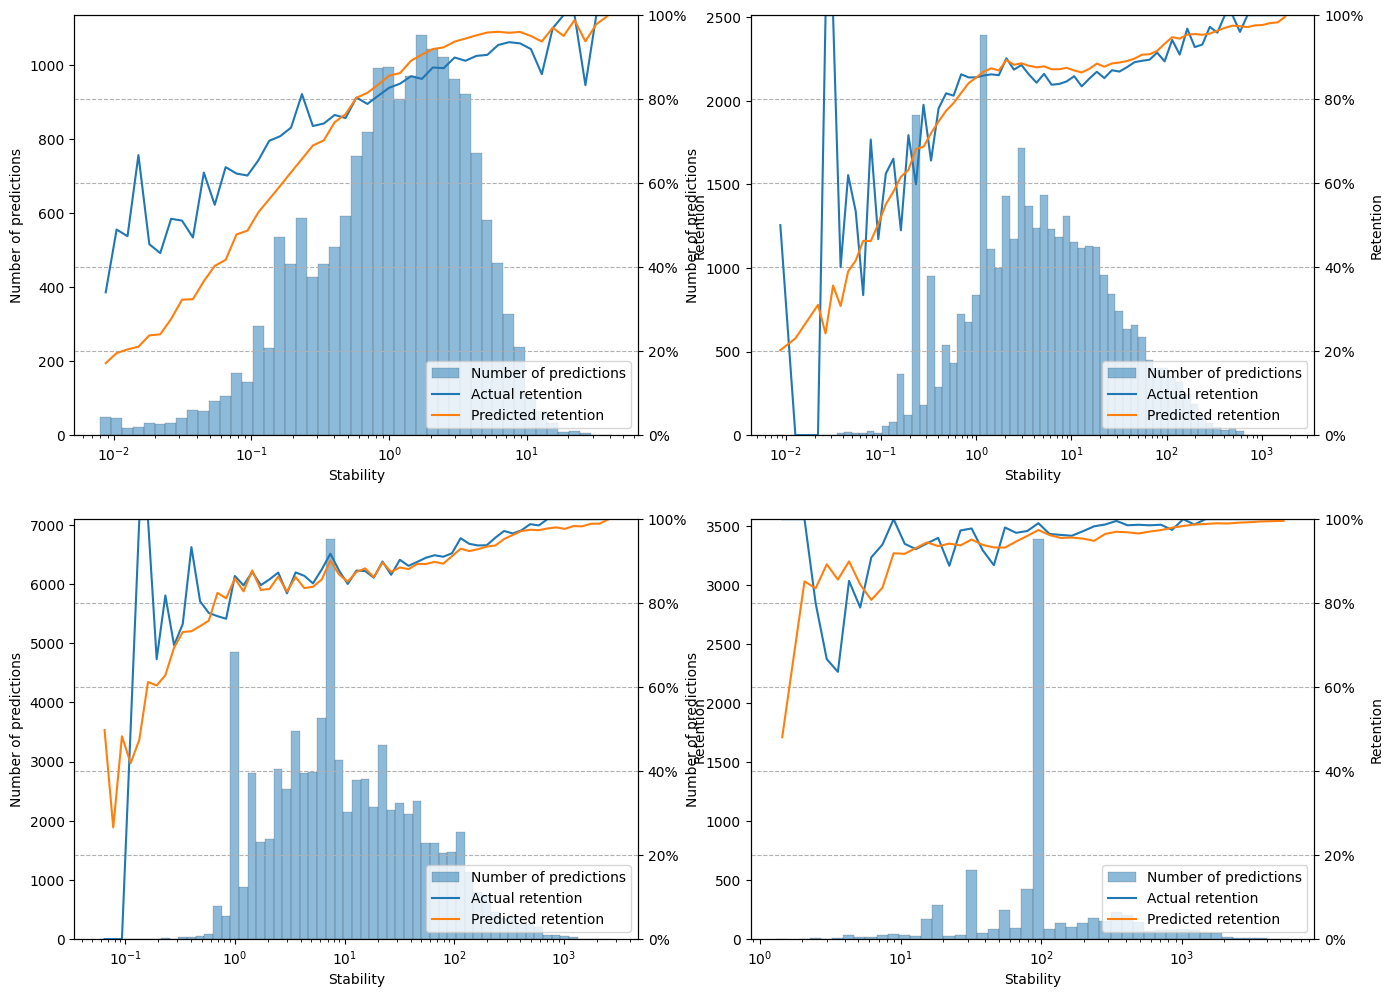

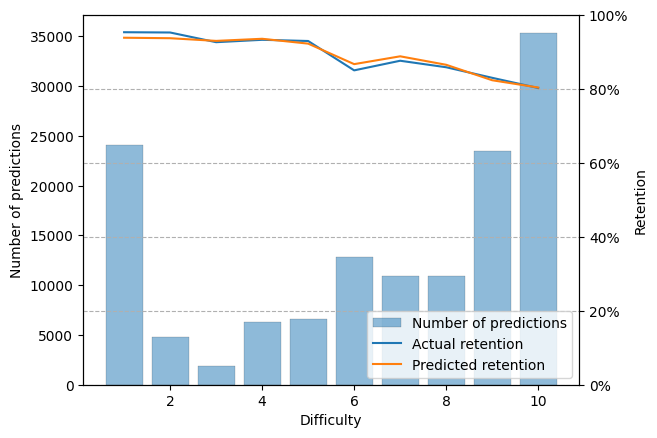

In [4]:
from fsrs_optimizer import Collection, power_forgetting_curve
from sklearn.metrics import log_loss

results = []

for w, dataset in zip(ws, datasets):
    my_collection = Collection(w)
    stabilities, difficulties = my_collection.batch_predict(dataset)
    dataset["stability"] = stabilities
    dataset["difficulty"] = difficulties
    dataset["p"] = power_forgetting_curve(dataset["delta_t"], dataset["stability"])
    results.append(dataset.copy())

dataset_join = pd.concat(results, ignore_index=True)
print(f"log loss: {log_loss(dataset_join['y'], dataset_join['p']):.4f}")
optimizer.calibration_graph(dataset_join)

  0%|          | 0/137144 [00:00<?, ?it/s]

log loss: 0.3606
RMSE(bins): 0.0347

Last rating: 1
RMSE(bins): 0.0606

Last rating: 2
RMSE(bins): 0.0432

Last rating: 3
RMSE(bins): 0.0363

Last rating: 4
RMSE(bins): 0.0361


({'all': {'R-squared': 0.8284131402980794,
   'MAE': 0.02260077488816065,
   'ICI': 0.019824507468382435,
   'E50': 0.01084875267847979,
   'E90': 0.04435041361406461,
   'EMax': 0.32665299095258454,
   'RMSE(bins)': 0.03469409421410954,
   'AUC': 0.7126395941331021},
  1: {'R-squared': 0.6052403213971318,
   'MAE': 0.05570130612831072,
   'ICI': 0.05270779931628337,
   'E50': 0.04674601538060247,
   'E90': 0.09945201020578498,
   'EMax': 0.25609638915354005,
   'RMSE(bins)': 0.060563376170039415,
   'AUC': 0.6807799369314336},
  2: {'R-squared': 0.7682369567325877,
   'MAE': 0.0336880908457926,
   'ICI': 0.03035164577049948,
   'E50': 0.027336351523034264,
   'E90': 0.03661867667473553,
   'EMax': 0.3159529496709667,
   'RMSE(bins)': 0.04318927380008884,
   'AUC': 0.6867460731777063},
  3: {'R-squared': 0.787149564635701,
   'MAE': 0.019577830927434203,
   'ICI': 0.01646395977383616,
   'E50': 0.006183092490753106,
   'E90': 0.0431675215614397,
   'EMax': 0.31601124636492317,
   'RMSE

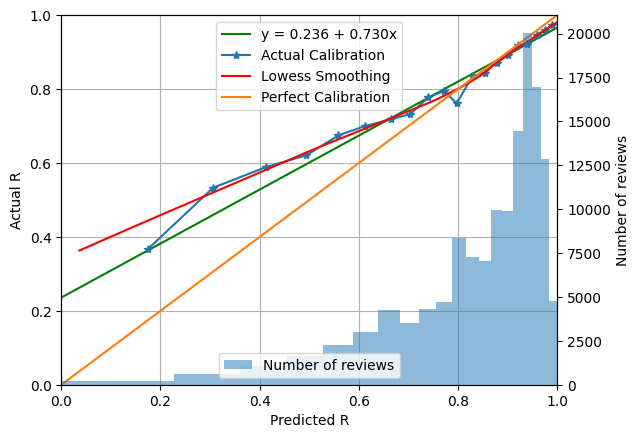

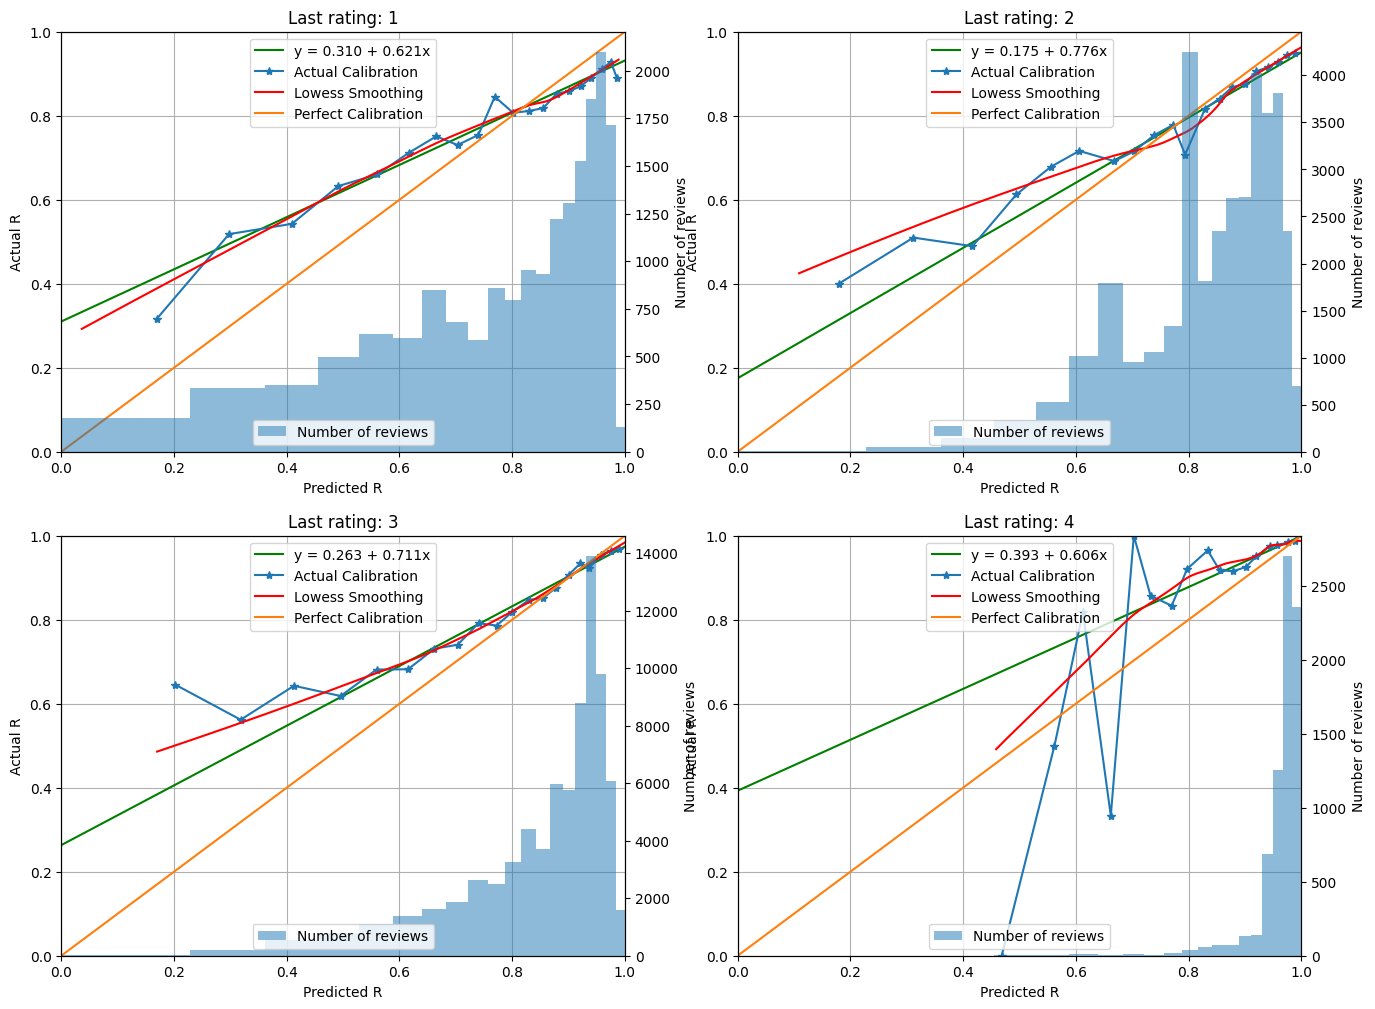

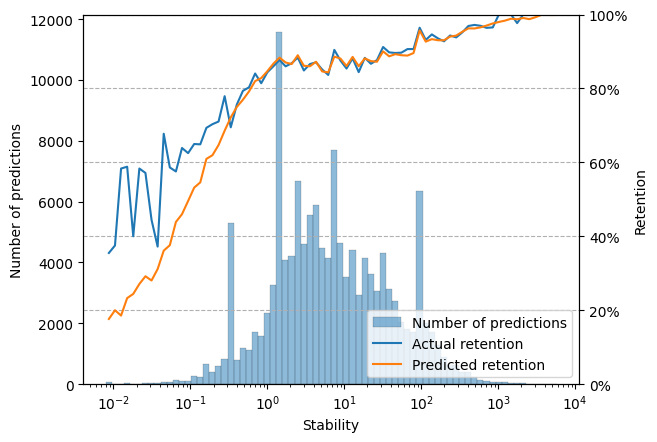

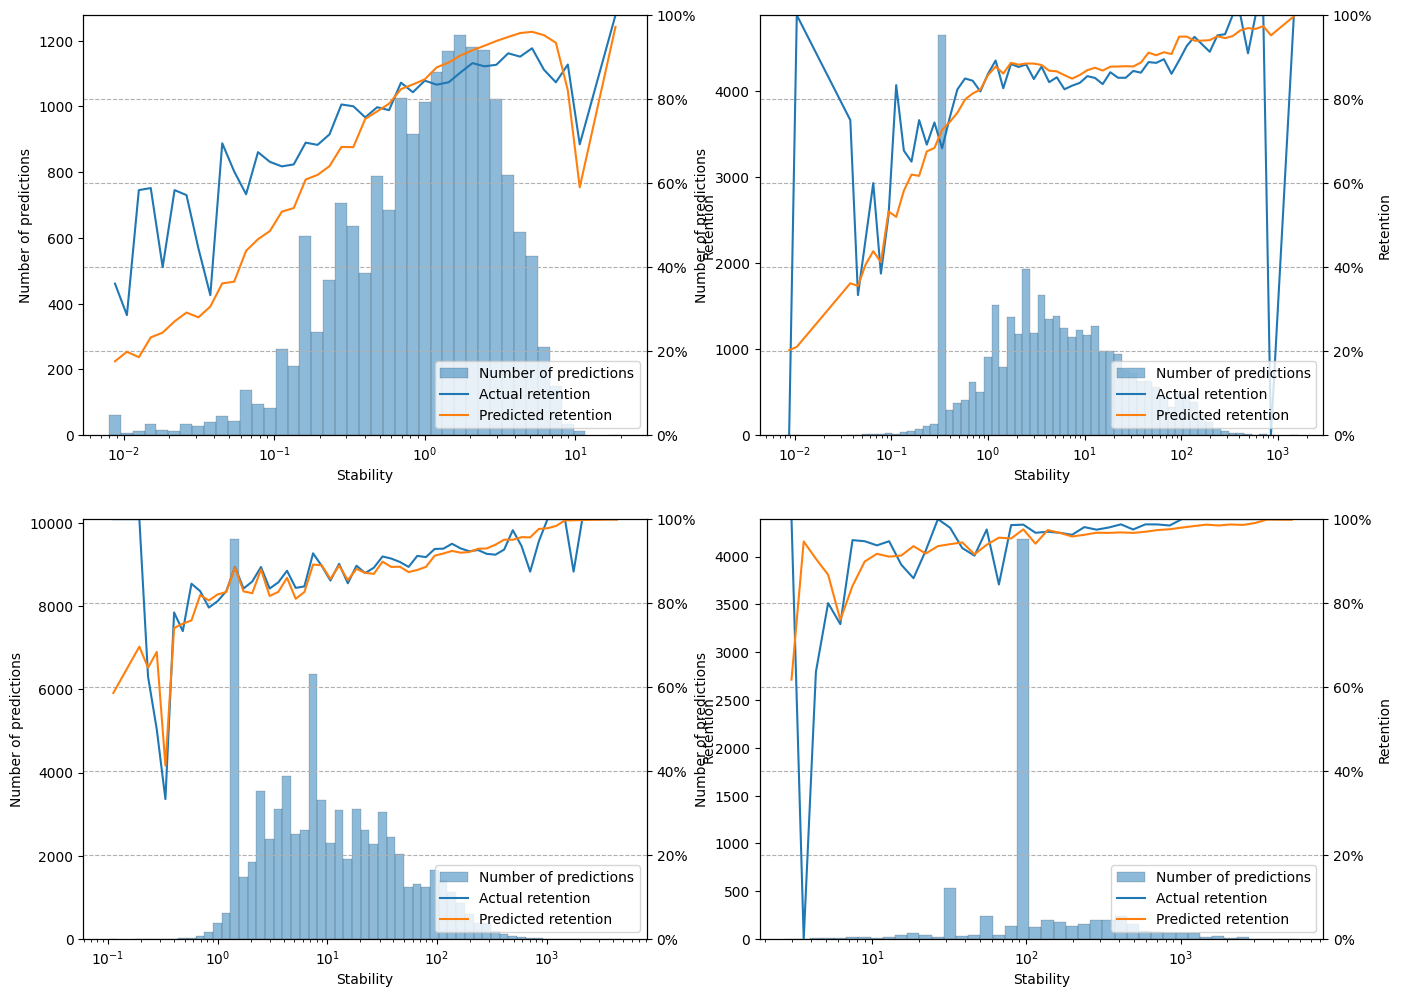

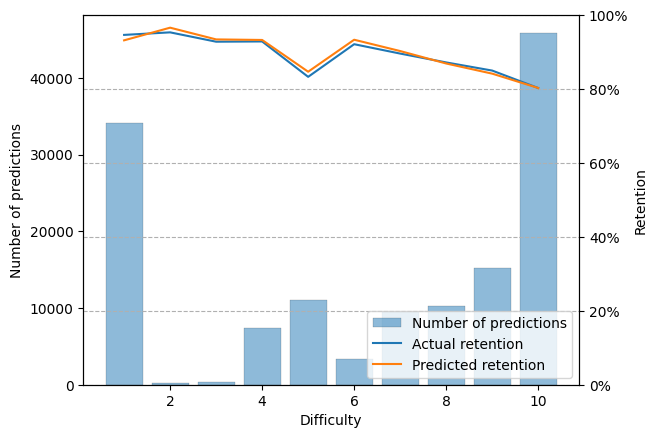

In [5]:
optimizer.define_model()
S0_dataset = dataset_join[dataset_join["i"] == 2].copy()
optimizer.S0_dataset_group = (
    S0_dataset.groupby(by=["first_rating", "delta_t"], group_keys=False)
    .agg({"y": ["mean", "count"]})
    .reset_index()
)
optimizer.pretrain(dataset_join.copy(), verbose=False)
optimizer.train(verbose=False)
optimizer.evaluate()
print(f"log loss: {log_loss(optimizer.dataset['y'], optimizer.dataset['p']):.4f}")
optimizer.calibration_graph()

In [6]:
for w, (name, df) in zip(ws, dfs):
    print(name, len(df), w, sep="\n")
    print()

print("Global", optimizer.w, sep="\n")

Main::Japanese::WaniKani::Vocabulary
34407
[1.1935, 0.3517, 1.4639, 19.7466, 7.0469, 0.8565, 1.7766, 0.001, 1.6372, 0.1666, 1.1265, 2.009, 0.0776, 0.2071, 2.032, 0.1657, 3.3818, 0.5254, 1.1658]

Main::Programming::Python::Syntax
1131
[0.1506, 0.5602, 1.3351, 15.8178, 7.1681, 0.5879, 1.6078, 0.001, 1.5397, 0.126, 1.013, 1.9645, 0.0862, 0.2937, 2.2157, 0.1923, 3.1397, 0.4425, 0.6551]

Main::Japanese::WaniKani::Kanji
24238
[0.1398, 0.1768, 0.7463, 16.7321, 7.0623, 0.3356, 1.8926, 0.0168, 1.5017, 0.1754, 1.0527, 1.9089, 0.0986, 0.148, 2.1257, 0.1955, 3.47, 0.5512, 1.2474]

Main::Science::Mechanisms
1402
[0.1713, 1.384, 4.3612, 4.3312, 7.3012, 0.3857, 1.6165, 0.0208, 1.3837, 0.2234, 0.8572, 1.9294, 0.085, 0.2653, 2.3244, 0.1219, 2.7723, 0.4451, 0.7104]

Main::Science::Chemistry
6543
[1.1461, 0.9564, 1.77, 32.548, 6.9361, 0.7028, 1.8537, 0.001, 1.6277, 0.0, 1.0666, 1.8965, 0.1418, 0.2314, 2.1607, 0.2411, 3.3412, 0.5159, 0.8952]

Main::Geography::Россия
1333
[0.0106, 0.1473, 0.3904, 15.8848, 